In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')
import os

In [3]:
# ==========================================
# PASSO 1: CARREGAR OS DADOS
# ==========================================

print("\nCarregando dados...")
df_satd = pd.read_csv('/content/drive/MyDrive/TI6/sadts_classificadas_IA.csv')
df_notebooks = pd.read_csv('/content/drive/MyDrive/TI6/all_notebooks_data.csv')

print(f"✓ SATD classificados: {len(df_satd)} registros")
print(f"✓ Notebooks catalogados: {len(df_notebooks)} registros")

# ==========================================
# PASSO 2: PREPARAR MAPEAMENTO DE NOTEBOOKS
# ==========================================

print("\n🔧 Preparando mapeamento de notebooks...")

def extrair_ref_do_path(path):
 """Extrai a referência do notebook do file_path"""
 if pd.isna(path):
     return None
 # Remove .ipynb e pega as duas últimas partes do path
 # Ex: Dados_Tabulares\house-prices..\notebook-name\notebook-name.ipynb
 # -> notebook-name
 parts = path.replace('.ipynb', '').split('\\')
 if len(parts) >= 2:
     # Pega o nome do notebook (penúltima parte)
     return parts[-1]
 return None

df_satd['notebook_ref'] = df_satd['file_path'].apply(extrair_ref_do_path)

# Criar mapeamento de tipo de dívida para coluna
def limpar_tipo_divida(tipo):
 """Limpa e normaliza o tipo de dívida"""
 if pd.isna(tipo):
     return None
 tipo_limpo = re.sub(r'\s*\([^)]*\)', '', str(tipo)).strip().lower()
 return tipo_limpo

df_satd['tipo_limpo'] = df_satd['tipo_de_divida'].apply(limpar_tipo_divida)

# Mapeamento de tipos de dívida para colunas
mapeamento_colunas = {
 'data dependency': 'dataDependency',
 'dependência de dados': 'dataDependency',
 'code dependency': 'codeDependency',
 'dependência de código': 'codeDependency',
 'awareness': 'awareness',
 'consciência/conhecimento': 'awareness',
 'modularity': 'modularity',
 'modularidade': 'modularity',
 'configurable options': 'configurableOptions',
 'configurável/configuração temporária': 'configurableOptions',
 'opções configuráveis': 'configurableOptions',
 'scalability': 'scalability',
 'escalabilidade': 'scalability',
 'readability': 'readability',
 'legibilidade': 'readability',
 'performance': 'performance',
 'workaround': 'codeDependency',  # Classificando workaround como code dependency
 'workaround temporário': 'codeDependency',
 'workaround / código temporário': 'codeDependency',
 'falta de implementação/pendência': 'awareness',
 'duplicate code elimination': 'duplicateCodeElimination'
}

print(f"✓ {len(df_satd['notebook_ref'].unique())} notebooks únicos com SATD")

# ==========================================
# PASSO 3: CONSOLIDAR DADOS
# ==========================================

print("\n🔄 Consolidando dados...")

# Criar cópia do dataframe de notebooks
df_consolidated = df_notebooks.copy()

# Colunas de SATD
satd_columns = ['dataDependency', 'codeDependency', 'awareness', 'modularity',
             'configurableOptions', 'scalability', 'readability', 'performance',
             'duplicateCodeElimination']

# Resetar colunas de SATD para 0
for col in satd_columns:
 df_consolidated[col] = 0

# Agrupar SATDs por notebook
satd_por_notebook = df_satd.groupby('notebook_ref').agg({
 'tipo_limpo': lambda x: list(x)
}).reset_index()

satd_por_notebook.columns = ['notebook_ref', 'tipos_satd']

# Preencher as colunas de SATD
notebooks_atualizados = 0
notebooks_nao_encontrados = []

for idx, row in satd_por_notebook.iterrows():
 notebook_ref = row['notebook_ref']
 tipos = row['tipos_satd']

 # Encontrar o índice no df_consolidated
 mask = df_consolidated['ref'].str.contains(notebook_ref, case=False, na=False, regex=False)

 if mask.any():
     notebook_idx = df_consolidated[mask].index[0]

     # Marcar as colunas apropriadas com 1
     for tipo in tipos:
         if tipo and tipo in mapeamento_colunas:
             coluna = mapeamento_colunas[tipo]
             df_consolidated.at[notebook_idx, coluna] = 1

     notebooks_atualizados += 1
 else:
     notebooks_nao_encontrados.append(notebook_ref)

print(f"✓ Notebooks atualizados: {notebooks_atualizados}")
print(f"⚠ Notebooks não encontrados: {len(notebooks_nao_encontrados)}")

# ==========================================
# PASSO 4: FILTRAR NOTEBOOKS COM SATD
# ==========================================

print("\n🔍 Filtrando notebooks com SATD...")

# Criar coluna com total de SATDs
df_consolidated['total_satds'] = df_consolidated[satd_columns].sum(axis=1)

# Filtrar apenas notebooks com pelo menos 1 SATD
df_with_satd = df_consolidated[df_consolidated['total_satds'] > 0].copy()

print(f"✓ Notebooks SEM SATD removidos: {len(df_consolidated) - len(df_with_satd)}")
print(f"✓ Notebooks COM SATD: {len(df_with_satd)}")

# Salvar dataset consolidado
df_with_satd.to_csv('notebooks_com_satd_consolidado.csv', index=False)
print("\n💾 Dataset consolidado salvo: 'notebooks_com_satd_consolidado.csv'")


Carregando dados...
✓ SATD classificados: 60 registros
✓ Notebooks catalogados: 3600 registros

🔧 Preparando mapeamento de notebooks...
✓ 33 notebooks únicos com SATD

🔄 Consolidando dados...
✓ Notebooks atualizados: 33
⚠ Notebooks não encontrados: 0

🔍 Filtrando notebooks com SATD...
✓ Notebooks SEM SATD removidos: 3567
✓ Notebooks COM SATD: 33

💾 Dataset consolidado salvo: 'notebooks_com_satd_consolidado.csv'


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



📁 Diretório criado/verificado: graficos_analise_satd/

RQ1: CATEGORIAS PREVALENTES DE SATD EM NOTEBOOKS DO KAGGLE

📊 Distribuição de Tipos de SATD:
------------------------------------------------------------
            Tipo de SATD  Quantidade de Notebooks  Percentual (%)
          dataDependency                        9           27.27
               awareness                        9           27.27
          codeDependency                        8           24.24
             readability                        6           18.18
              modularity                        3            9.09
     configurableOptions                        3            9.09
             scalability                        3            9.09
             performance                        3            9.09
duplicateCodeElimination                        0            0.00
✓ Gráfico salvo: RQ1_01_barras_tipos_satd.png


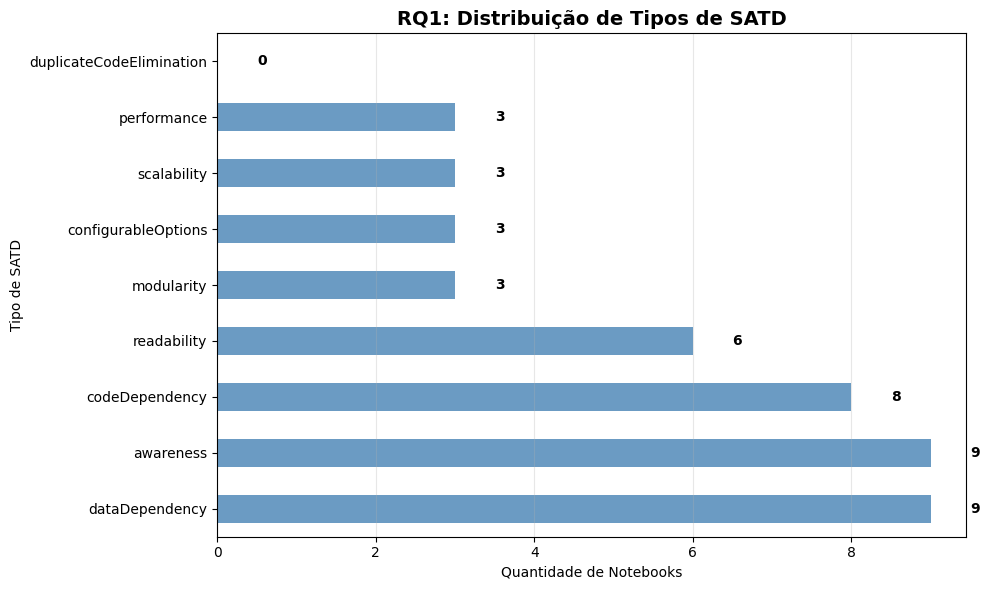

✓ Gráfico salvo: RQ1_02_pizza_tipos_satd.png


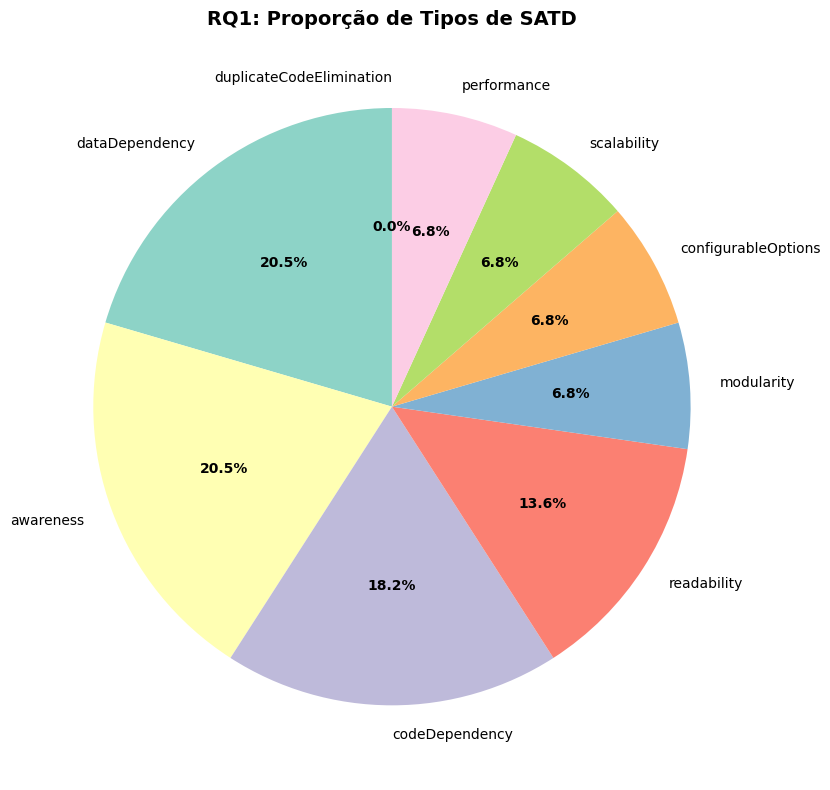


RQ2: CORRELAÇÃO ENTRE SATD E MÉTRICAS DE SUCESSO (totalVotes)

📈 Estatísticas de Total Votes:
------------------------------------------------------------
count        33.000000
mean      14379.212121
std       74097.995245
min           8.000000
25%          25.000000
50%         101.000000
75%         345.000000
max      426522.000000
Name: totalVotes, dtype: float64

📊 Correlação entre Total SATDs e Total Votes: 0.2402

🔍 Correlação de cada tipo de SATD com Total Votes:
------------------------------------------------------------
dataDependency: 0.2775
codeDependency: -0.0951
awareness: -0.1176
modularity: -0.0588
configurableOptions: -0.0422
scalability: -0.0605
readability: 0.3810
performance: -0.0616
duplicateCodeElimination: nan
✓ Gráfico salvo: RQ2_01_scatter_satds_vs_votes.png


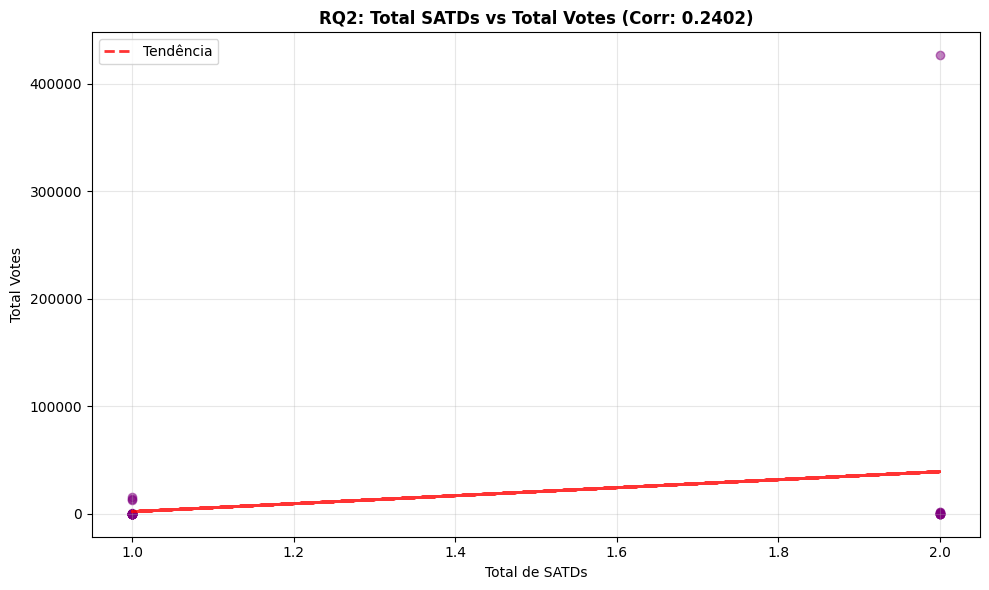

✓ Gráfico salvo: RQ2_02_boxplot_votes_por_satd.png


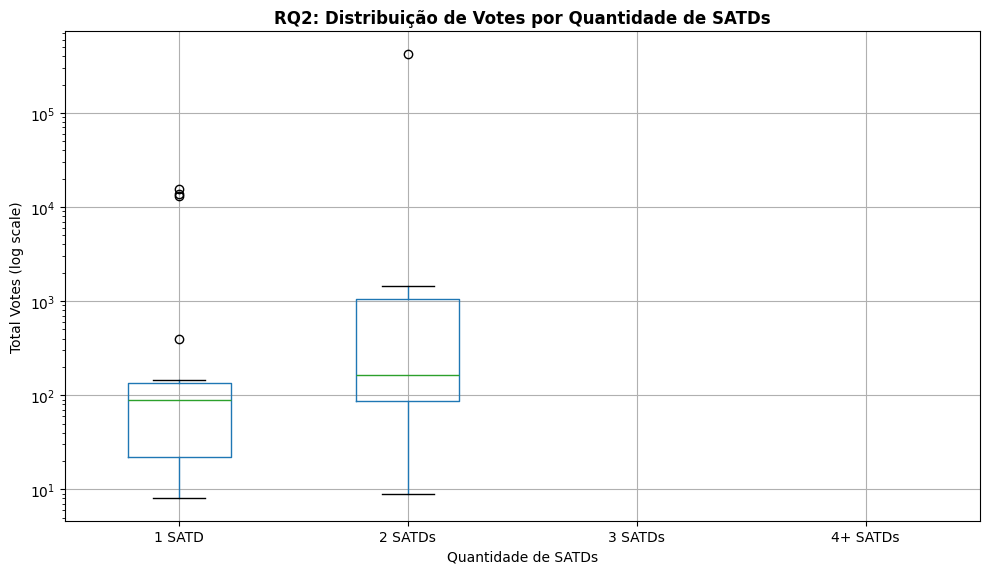

✓ Gráfico salvo: RQ2_03_correlacoes_por_tipo.png


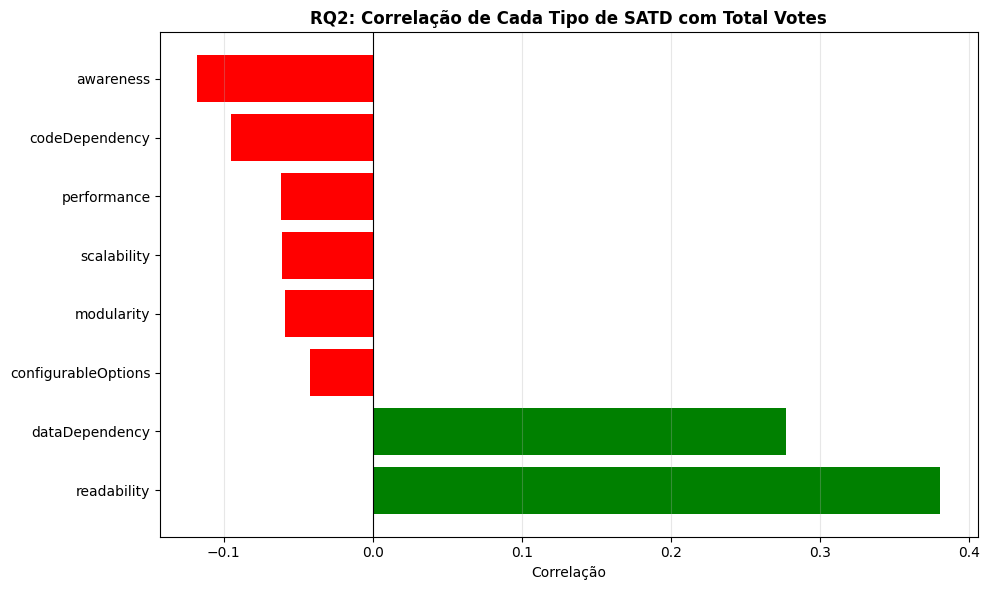

✓ Gráfico salvo: RQ2_04_media_votes_com_sem_satd.png


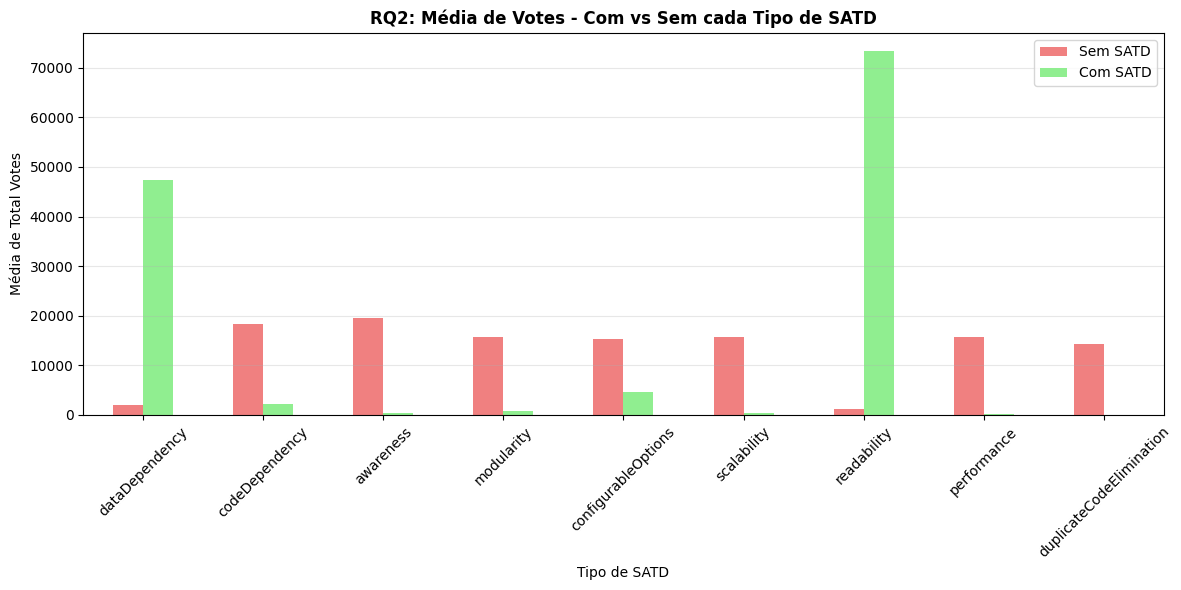


📊 Análise de Total Votes por Presença de SATD:
------------------------------------------------------------

dataDependency:
  Média COM SATD: 47450 votes
  Média SEM SATD: 1978 votes
  Diferença: +2299.5%

codeDependency:
  Média COM SATD: 2109 votes
  Média SEM SATD: 18306 votes
  Diferença: -88.5%

awareness:
  Média COM SATD: 363 votes
  Média SEM SATD: 19635 votes
  Diferença: -98.2%

modularity:
  Média COM SATD: 809 votes
  Média SEM SATD: 15736 votes
  Diferença: -94.9%

configurableOptions:
  Média COM SATD: 4631 votes
  Média SEM SATD: 15354 votes
  Diferença: -69.8%

scalability:
  Média COM SATD: 418 votes
  Média SEM SATD: 15775 votes
  Diferença: -97.3%

readability:
  Média COM SATD: 73360 votes
  Média SEM SATD: 1272 votes
  Diferença: +5665.6%

performance:
  Média COM SATD: 155 votes
  Média SEM SATD: 15802 votes
  Diferença: -99.0%

RQ3: DISTRIBUIÇÃO DE CATEGORIAS DE SATD POR DOMÍNIO

🌍 Domínios encontrados: ['Dados Tabulares', 'NLP']

📊 Contagem de SATDs por Domíni

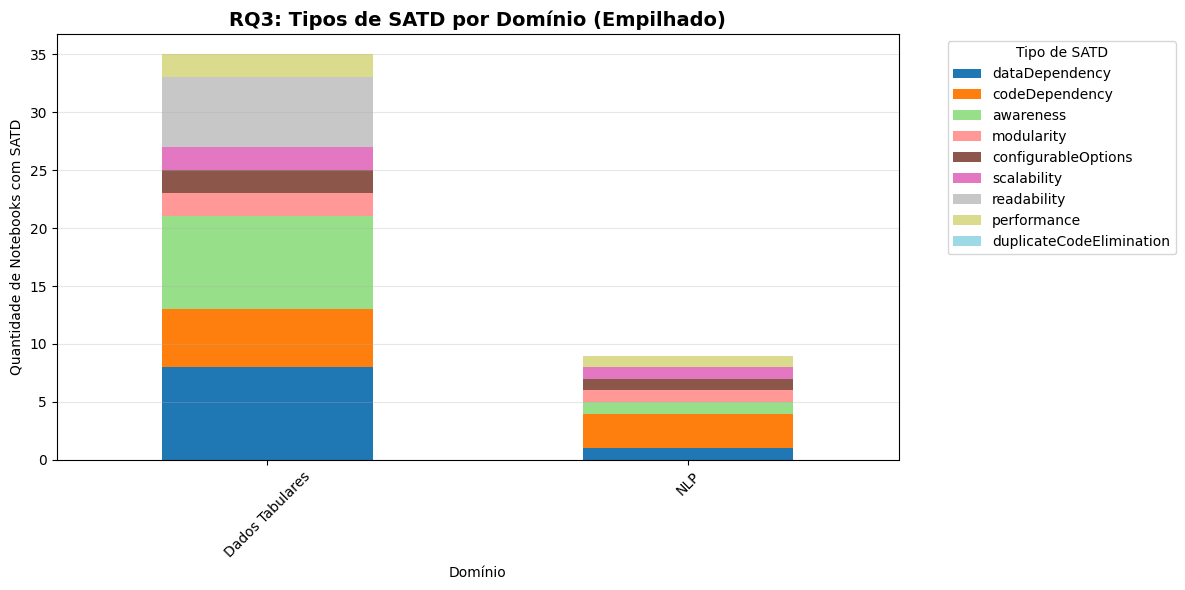

✓ Gráfico salvo: RQ3_02_grouped_bar_dominio.png


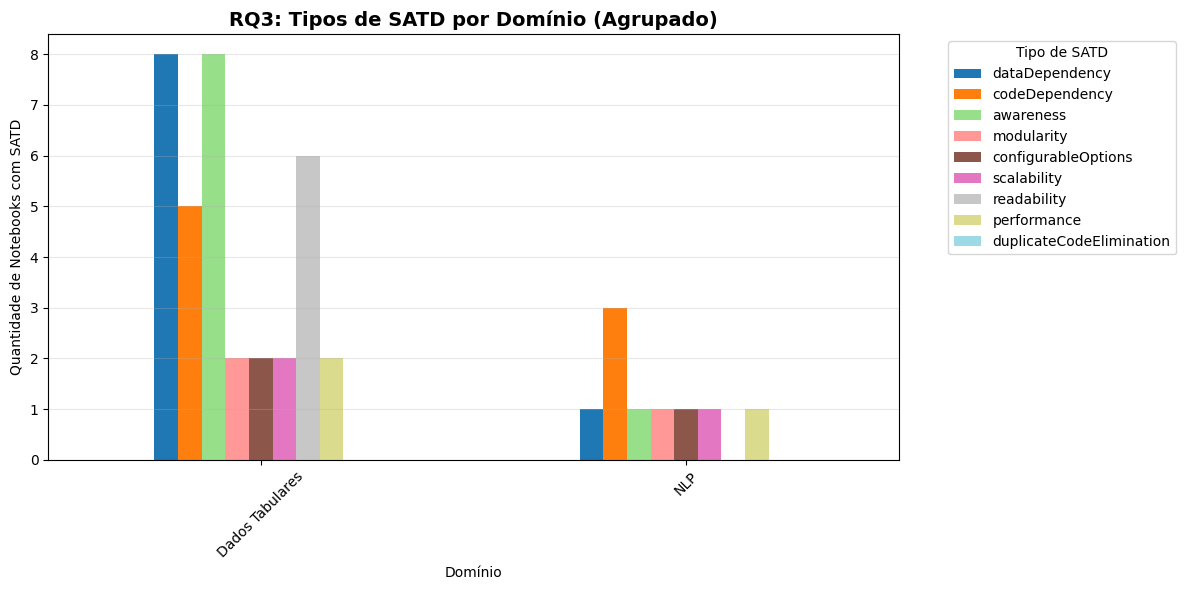

✓ Gráfico salvo: RQ3_03_heatmap_dominio.png


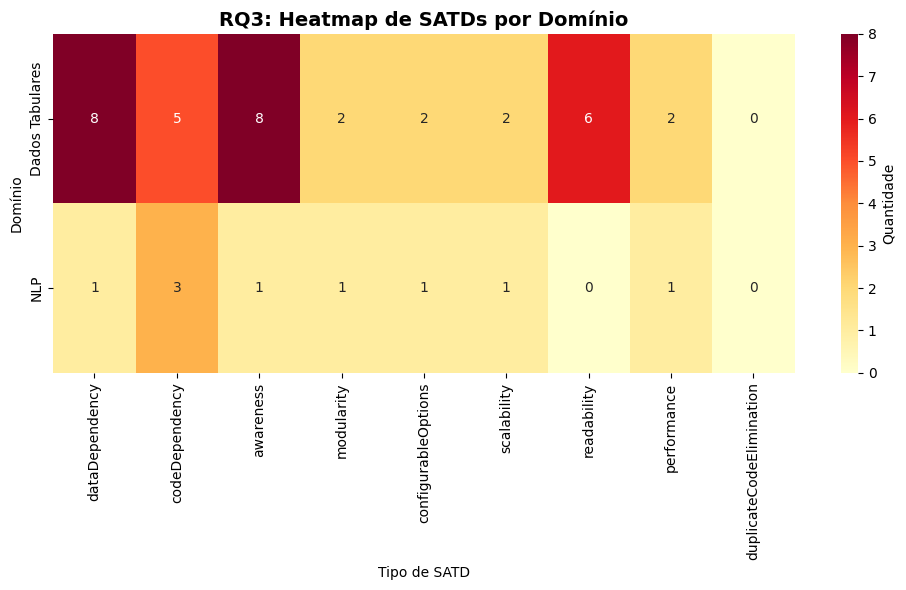

✓ Gráfico salvo: RQ3_04_total_satds_por_dominio.png


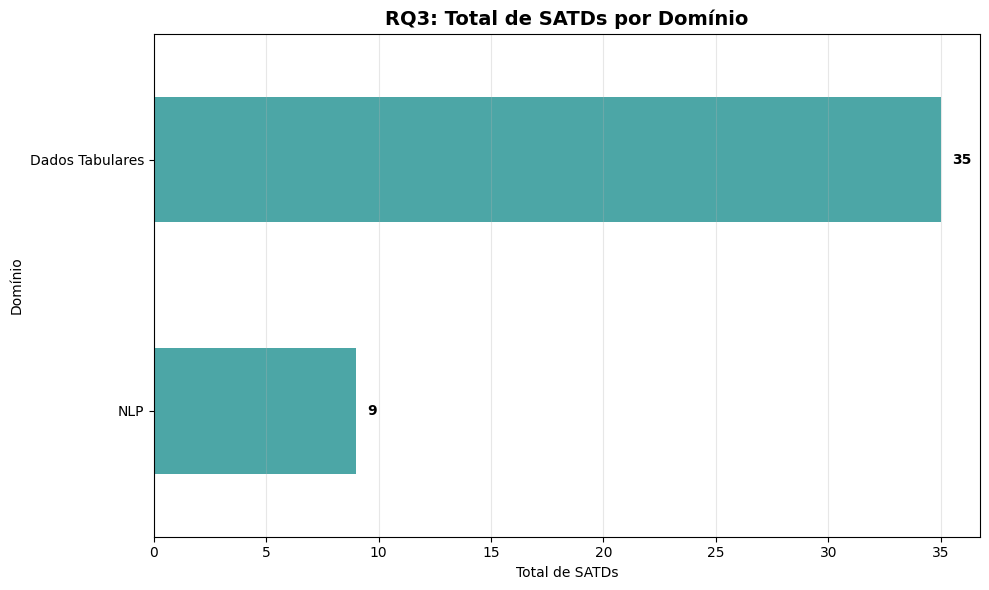


📈 Estatísticas Detalhadas por Domínio:
--------------------------------------------------------------------------------

🔹 Dados Tabulares:
  Notebooks com SATD: 26
  Total de SATDs: 35
  Média de SATDs por notebook: 1.35
  Média de Votes: 18238
  Tipo mais comum: dataDependency (8 notebooks)

🔹 NLP:
  Notebooks com SATD: 7
  Total de SATDs: 9
  Média de SATDs por notebook: 1.29
  Média de Votes: 46
  Tipo mais comum: codeDependency (3 notebooks)

📋 SUMÁRIO EXECUTIVO

PRINCIPAIS ACHADOS:

1️⃣ RQ1 - Categorias Prevalentes:
• Total de notebooks COM SATD: 33
• Total de notebooks ANALISADOS: 3600
• Percentual com SATD: 0.9%
• Categoria mais prevalente: dataDependency 
(9 notebooks, 27.27%)
• Total de SATDs identificados: 44

2️⃣ RQ2 - Relação com Sucesso (Total Votes):
• Correlação geral: 0.2402
• Tipo com maior correlação positiva: readability 
(r=0.3810)
• Média de votes (notebooks COM SATD): 14379
• Média de votes (notebooks SEM SATD): 242

3️⃣ RQ3 - Distribuição por Domínio:
• Domínio

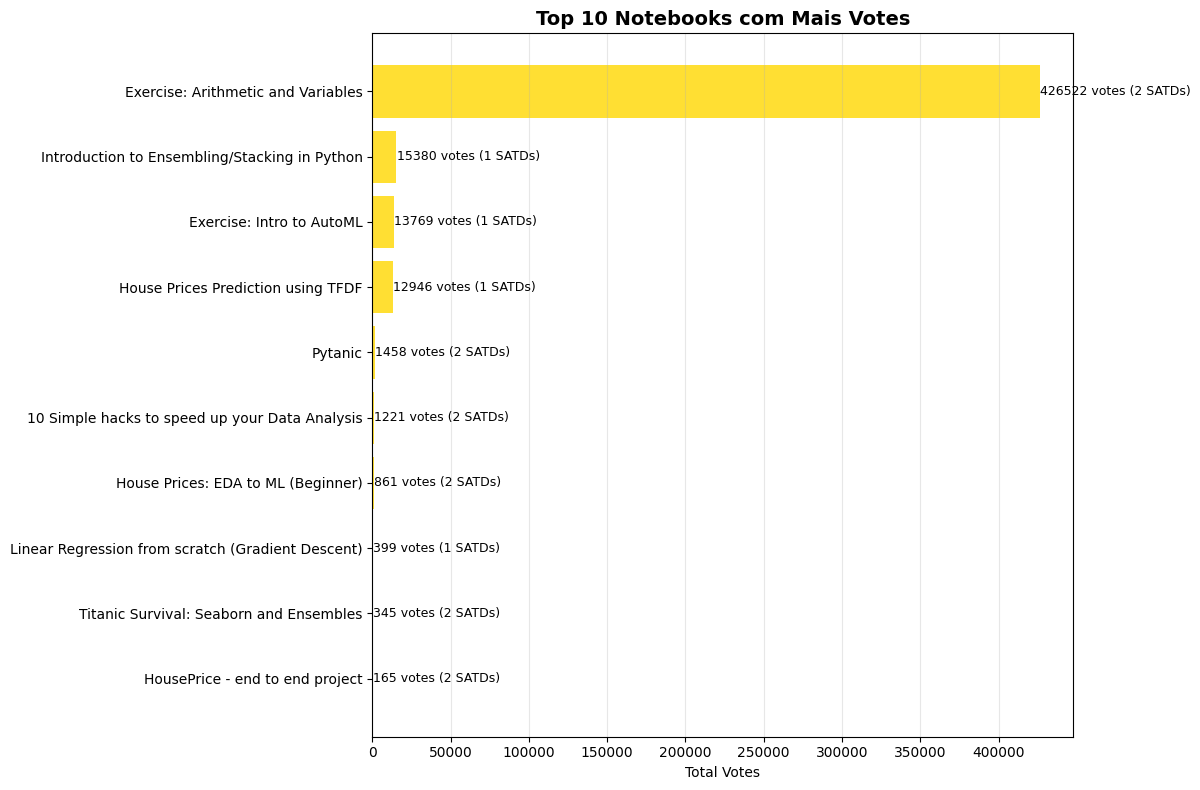

✓ Gráfico salvo: TOP_02_notebooks_mais_satds.png


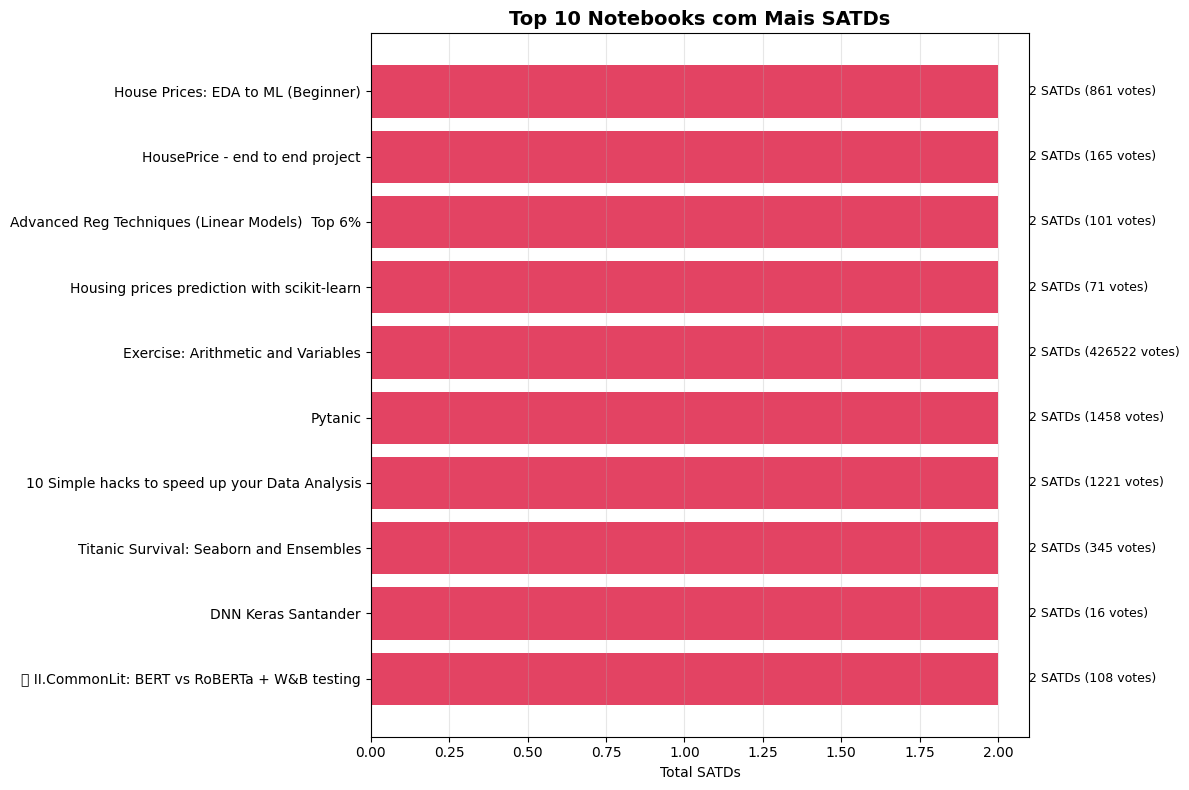


📦 RESUMO DE ARQUIVOS GERADOS

📊 GRÁFICOS PNG (300 DPI) - TOTAL: 12 arquivos

  🔵 RQ1 - Categorias Prevalentes (2 gráficos):
    • graficos_analise_satd/RQ1_01_barras_tipos_satd.png
    • graficos_analise_satd/RQ1_02_pizza_tipos_satd.png

  🟢 RQ2 - Correlação com Sucesso (4 gráficos):
    • graficos_analise_satd/RQ2_01_scatter_satds_vs_votes.png
    • graficos_analise_satd/RQ2_02_boxplot_votes_por_satd.png
    • graficos_analise_satd/RQ2_03_correlacoes_por_tipo.png
    • graficos_analise_satd/RQ2_04_media_votes_com_sem_satd.png

  🟣 RQ3 - Distribuição por Domínio (4 gráficos):
    • graficos_analise_satd/RQ3_01_stacked_bar_dominio.png
    • graficos_analise_satd/RQ3_02_grouped_bar_dominio.png
    • graficos_analise_satd/RQ3_03_heatmap_dominio.png
    • graficos_analise_satd/RQ3_04_total_satds_por_dominio.png

  🟠 TOP Notebooks (2 gráficos):
    • graficos_analise_satd/TOP_01_notebooks_mais_votes.png
    • graficos_analise_satd/TOP_02_notebooks_mais_satds.png

📋 TABELAS CSV (6 arquivos)

In [8]:
# Criar diretório para salvar os gráficos
output_dir = 'graficos_analise_satd'
os.makedirs(output_dir, exist_ok=True)
print(f"\n📁 Diretório criado/verificado: {output_dir}/")

# ==========================================
# RQ1: CATEGORIAS PREVALENTES DE SATD
# ==========================================

print("\n" + "="*80)
print("RQ1: CATEGORIAS PREVALENTES DE SATD EM NOTEBOOKS DO KAGGLE")
print("="*80)

# Contar SATDs por tipo
satd_counts = df_with_satd[satd_columns].sum().sort_values(ascending=False)
satd_percentages = (satd_counts / len(df_with_satd) * 100).round(2)

resultado_rq1 = pd.DataFrame({
  'Tipo de SATD': satd_counts.index,
  'Quantidade de Notebooks': satd_counts.values,
  'Percentual (%)': satd_percentages.values
})

print("\n📊 Distribuição de Tipos de SATD:")
print("-" * 60)
print(resultado_rq1.to_string(index=False))

# ========== GRÁFICO 1: Barras Horizontais ==========
fig, ax = plt.subplots(figsize=(10, 6))
satd_counts.plot(kind='barh', ax=ax, color='steelblue', alpha=0.8)
ax.set_title('RQ1: Distribuição de Tipos de SATD', fontsize=14, fontweight='bold')
ax.set_xlabel('Quantidade de Notebooks')
ax.set_ylabel('Tipo de SATD')
ax.grid(axis='x', alpha=0.3)

for i, v in enumerate(satd_counts.values):
  ax.text(v + 0.5, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{output_dir}/RQ1_01_barras_tipos_satd.png', dpi=300, bbox_inches='tight')
print(f"✓ Gráfico salvo: RQ1_01_barras_tipos_satd.png")
plt.show()
plt.close()

# ========== GRÁFICO 2: Pizza ==========
fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.Set3(range(len(satd_counts)))
wedges, texts, autotexts = ax.pie(satd_counts.values, labels=satd_counts.index,
                                  autopct='%1.1f%%', startangle=90, colors=colors)
ax.set_title('RQ1: Proporção de Tipos de SATD', fontsize=14, fontweight='bold')

for autotext in autotexts:
  autotext.set_color('black')
  autotext.set_fontweight('bold')
  autotext.set_fontsize(10)

plt.tight_layout()
plt.savefig(f'{output_dir}/RQ1_02_pizza_tipos_satd.png', dpi=300, bbox_inches='tight')
print(f"✓ Gráfico salvo: RQ1_02_pizza_tipos_satd.png")
plt.show()
plt.close()

# ==========================================
# RQ2: CORRELAÇÃO COM SUCESSO E VISIBILIDADE
# ==========================================

print("\n" + "="*80)
print("RQ2: CORRELAÇÃO ENTRE SATD E MÉTRICAS DE SUCESSO (totalVotes)")
print("="*80)

# Estatísticas descritivas
print(f"\n📈 Estatísticas de Total Votes:")
print("-" * 60)
print(df_with_satd['totalVotes'].describe())

# Correlação entre total de SATDs e totalVotes
correlation = df_with_satd[['total_satds', 'totalVotes']].corr().iloc[0, 1]
print(f"\n📊 Correlação entre Total SATDs e Total Votes: {correlation:.4f}")

# Análise detalhada por tipo de SATD
print(f"\n🔍 Correlação de cada tipo de SATD com Total Votes:")
print("-" * 60)
correlacoes = {}
for col in satd_columns:
  corr = df_with_satd[[col, 'totalVotes']].corr().iloc[0, 1]
  correlacoes[col] = corr
  print(f"{col}: {corr:.4f}")

# ========== GRÁFICO 3: Scatter - Total SATDs vs Total Votes ==========
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df_with_satd['total_satds'], df_with_satd['totalVotes'],
         alpha=0.5, color='purple')
ax.set_title(f'RQ2: Total SATDs vs Total Votes (Corr: {correlation:.4f})',
           fontsize=12, fontweight='bold')
ax.set_xlabel('Total de SATDs')
ax.set_ylabel('Total Votes')
ax.grid(alpha=0.3)

# Adicionar linha de tendência
z = np.polyfit(df_with_satd['total_satds'], df_with_satd['totalVotes'], 1)
p = np.poly1d(z)
ax.plot(df_with_satd['total_satds'], p(df_with_satd['total_satds']),
      "r--", alpha=0.8, linewidth=2, label='Tendência')
ax.legend()

plt.tight_layout()
plt.savefig(f'{output_dir}/RQ2_01_scatter_satds_vs_votes.png', dpi=300, bbox_inches='tight')
print(f"✓ Gráfico salvo: RQ2_01_scatter_satds_vs_votes.png")
plt.show()
plt.close()

# ========== GRÁFICO 4: Box plot - Votes por número de SATDs ==========
fig, ax = plt.subplots(figsize=(10, 6))
df_with_satd['satd_category'] = pd.cut(df_with_satd['total_satds'],
                                     bins=[0, 1, 2, 3, 100],
                                     labels=['1 SATD', '2 SATDs', '3 SATDs', '4+ SATDs'])
df_with_satd.boxplot(column='totalVotes', by='satd_category', ax=ax)
ax.set_title('RQ2: Distribuição de Votes por Quantidade de SATDs', fontsize=12, fontweight='bold')
ax.set_xlabel('Quantidade de SATDs')
ax.set_ylabel('Total Votes (log scale)')
ax.set_yscale('log')
plt.suptitle('')

plt.tight_layout()
plt.savefig(f'{output_dir}/RQ2_02_boxplot_votes_por_satd.png', dpi=300, bbox_inches='tight')
print(f"✓ Gráfico salvo: RQ2_02_boxplot_votes_por_satd.png")
plt.show()
plt.close()

# ========== GRÁFICO 5: Correlações por tipo ==========
fig, ax = plt.subplots(figsize=(10, 6))
correlacoes_df = pd.DataFrame({
  'SATD Type': list(correlacoes.keys()),
  'Correlation': list(correlacoes.values())
}).sort_values('Correlation', ascending=False)

ax.barh(correlacoes_df['SATD Type'], correlacoes_df['Correlation'],
      color=['green' if x >= 0 else 'red' for x in correlacoes_df['Correlation']])
ax.set_title('RQ2: Correlação de Cada Tipo de SATD com Total Votes',
           fontsize=12, fontweight='bold')
ax.set_xlabel('Correlação')
ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/RQ2_03_correlacoes_por_tipo.png', dpi=300, bbox_inches='tight')
print(f"✓ Gráfico salvo: RQ2_03_correlacoes_por_tipo.png")
plt.show()
plt.close()

# ========== GRÁFICO 6: Média de Votes por presença de SATD ==========
fig, ax = plt.subplots(figsize=(12, 6))
medias_votes = []
labels_satd = []
for col in satd_columns:
  media_com = df_with_satd[df_with_satd[col] == 1]['totalVotes'].mean()
  media_sem = df_with_satd[df_with_satd[col] == 0]['totalVotes'].mean()
  medias_votes.append([media_sem, media_com])
  labels_satd.append(col)

medias_df = pd.DataFrame(medias_votes, columns=['Sem SATD', 'Com SATD'], index=labels_satd)
medias_df.plot(kind='bar', ax=ax, color=['lightcoral', 'lightgreen'])
ax.set_title('RQ2: Média de Votes - Com vs Sem cada Tipo de SATD', fontsize=12, fontweight='bold')
ax.set_ylabel('Média de Total Votes')
ax.set_xlabel('Tipo de SATD')
ax.tick_params(axis='x', rotation=45)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/RQ2_04_media_votes_com_sem_satd.png', dpi=300, bbox_inches='tight')
print(f"✓ Gráfico salvo: RQ2_04_media_votes_com_sem_satd.png")
plt.show()
plt.close()

# Análise estatística
print(f"\n📊 Análise de Total Votes por Presença de SATD:")
print("-" * 60)
for col in satd_columns:
  com_satd = df_with_satd[df_with_satd[col] == 1]['totalVotes']
  sem_satd = df_with_satd[df_with_satd[col] == 0]['totalVotes']

  if len(com_satd) > 0 and len(sem_satd) > 0:
      print(f"\n{col}:")
      print(f"  Média COM SATD: {com_satd.mean():.0f} votes")
      print(f"  Média SEM SATD: {sem_satd.mean():.0f} votes")
      diferenca = ((com_satd.mean() - sem_satd.mean()) / sem_satd.mean() * 100)
      print(f"  Diferença: {diferenca:+.1f}%")

# ==========================================
# RQ3: DISTRIBUIÇÃO POR DOMÍNIO
# ==========================================

print("\n" + "="*80)
print("RQ3: DISTRIBUIÇÃO DE CATEGORIAS DE SATD POR DOMÍNIO")
print("="*80)

# Estatísticas por domínio
dominios_unicos = df_with_satd['domain'].unique()
print(f"\n🌍 Domínios encontrados: {list(dominios_unicos)}")

# Criar tabela de contingência
crosstab_domain = pd.DataFrame()
for col in satd_columns:
  crosstab_domain[col] = df_with_satd.groupby('domain')[col].sum()

print("\n📊 Contagem de SATDs por Domínio:")
print("-" * 80)
print(crosstab_domain)

# Percentual
crosstab_percent = crosstab_domain.div(crosstab_domain.sum(axis=1), axis=0) * 100
print("\n📊 Percentual de SATDs por Domínio (% dentro de cada domínio):")
print("-" * 80)
print(crosstab_percent.round(2))

# ========== GRÁFICO 7: Stacked bar ==========
fig, ax = plt.subplots(figsize=(12, 6))
crosstab_domain.plot(kind='bar', stacked=True, ax=ax, colormap='tab20')
ax.set_title('RQ3: Tipos de SATD por Domínio (Empilhado)',
           fontsize=14, fontweight='bold')
ax.set_xlabel('Domínio')
ax.set_ylabel('Quantidade de Notebooks com SATD')
ax.legend(title='Tipo de SATD', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/RQ3_01_stacked_bar_dominio.png', dpi=300, bbox_inches='tight')
print(f"✓ Gráfico salvo: RQ3_01_stacked_bar_dominio.png")
plt.show()
plt.close()

# ========== GRÁFICO 8: Grouped bar ==========
fig, ax = plt.subplots(figsize=(12, 6))
crosstab_domain.plot(kind='bar', ax=ax, colormap='tab20')
ax.set_title('RQ3: Tipos de SATD por Domínio (Agrupado)',
           fontsize=14, fontweight='bold')
ax.set_xlabel('Domínio')
ax.set_ylabel('Quantidade de Notebooks com SATD')
ax.legend(title='Tipo de SATD', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/RQ3_02_grouped_bar_dominio.png', dpi=300, bbox_inches='tight')
print(f"✓ Gráfico salvo: RQ3_02_grouped_bar_dominio.png")
plt.show()
plt.close()

# ========== GRÁFICO 9: Heatmap ==========
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(crosstab_domain, annot=True, fmt='d', cmap='YlOrRd', ax=ax,
          cbar_kws={'label': 'Quantidade'})
ax.set_title('RQ3: Heatmap de SATDs por Domínio', fontsize=14, fontweight='bold')
ax.set_xlabel('Tipo de SATD')
ax.set_ylabel('Domínio')

plt.tight_layout()
plt.savefig(f'{output_dir}/RQ3_03_heatmap_dominio.png', dpi=300, bbox_inches='tight')
print(f"✓ Gráfico salvo: RQ3_03_heatmap_dominio.png")
plt.show()
plt.close()

# ========== GRÁFICO 10: Total de SATDs por domínio ==========
fig, ax = plt.subplots(figsize=(10, 6))
total_por_dominio = df_with_satd.groupby('domain')['total_satds'].sum().sort_values(ascending=True)
total_por_dominio.plot(kind='barh', ax=ax, color='teal', alpha=0.7)
ax.set_title('RQ3: Total de SATDs por Domínio', fontsize=14, fontweight='bold')
ax.set_xlabel('Total de SATDs')
ax.set_ylabel('Domínio')
ax.grid(axis='x', alpha=0.3)

for i, v in enumerate(total_por_dominio.values):
  ax.text(v + 0.5, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{output_dir}/RQ3_04_total_satds_por_dominio.png', dpi=300, bbox_inches='tight')
print(f"✓ Gráfico salvo: RQ3_04_total_satds_por_dominio.png")
plt.show()
plt.close()

# Estatísticas detalhadas por domínio
print(f"\n📈 Estatísticas Detalhadas por Domínio:")
print("-" * 80)
for dominio in dominios_unicos:
  df_dominio = df_with_satd[df_with_satd['domain'] == dominio]
  print(f"\n🔹 {dominio}:")
  print(f"  Notebooks com SATD: {len(df_dominio)}")
  print(f"  Total de SATDs: {df_dominio['total_satds'].sum()}")
  print(f"  Média de SATDs por notebook: {df_dominio['total_satds'].mean():.2f}")
  print(f"  Média de Votes: {df_dominio['totalVotes'].mean():.0f}")

  # Tipo mais comum
  satd_counts_dominio = df_dominio[satd_columns].sum()
  tipo_mais_comum = satd_counts_dominio.idxmax()
  print(f"  Tipo mais comum: {tipo_mais_comum} ({satd_counts_dominio[tipo_mais_comum]} notebooks)")

# ==========================================
# SUMÁRIO EXECUTIVO
# ==========================================

print("\n" + "="*80)
print("📋 SUMÁRIO EXECUTIVO")
print("="*80)

tipo_mais_prevalente = satd_counts.index[0]
quantidade_mais_prevalente = satd_counts.values[0]
percent_mais_prevalente = satd_percentages.values[0]

dominio_mais_satd = total_por_dominio.index[-1]
total_satd_dominio = total_por_dominio.values[-1]

sumario_texto = f"""
PRINCIPAIS ACHADOS:

1️⃣ RQ1 - Categorias Prevalentes:
• Total de notebooks COM SATD: {len(df_with_satd)}
• Total de notebooks ANALISADOS: {len(df_consolidated)}
• Percentual com SATD: {len(df_with_satd)/len(df_consolidated)*100:.1f}%
• Categoria mais prevalente: {tipo_mais_prevalente}
({quantidade_mais_prevalente} notebooks, {percent_mais_prevalente}%)
• Total de SATDs identificados: {df_with_satd['total_satds'].sum()}

2️⃣ RQ2 - Relação com Sucesso (Total Votes):
• Correlação geral: {correlation:.4f}
• Tipo com maior correlação positiva: {max(correlacoes.items(), key=lambda x: x[1])[0]}
(r={max(correlacoes.values()):.4f})
• Média de votes (notebooks COM SATD): {df_with_satd['totalVotes'].mean():.0f}
• Média de votes (notebooks SEM SATD): {df_consolidated[df_consolidated['total_satds']==0]['totalVotes'].mean():.0f}

3️⃣ RQ3 - Distribuição por Domínio:
• Domínio com mais SATDs: {dominio_mais_satd} ({total_satd_dominio} SATDs)
• Domínios analisados: {len(dominios_unicos)}
"""

print(sumario_texto)

# Tipo dominante por domínio
tipo_dominio_texto = "\n   • Tipo de SATD dominante por domínio:\n"
for dominio in dominios_unicos:
  df_dom = df_with_satd[df_with_satd['domain'] == dominio]
  tipo_dom = df_dom[satd_columns].sum().idxmax()
  qtd = df_dom[satd_columns].sum().max()
  tipo_dominio_linha = f"     - {dominio}: {tipo_dom} ({qtd} notebooks)\n"
  print(tipo_dominio_linha, end='')
  tipo_dominio_texto += tipo_dominio_linha

print("\n" + "="*80)
print("✅ ANÁLISE CONCLUÍDA COM SUCESSO!")
print("="*80)

# Salvar resultados
print("\n💾 Salvando resultados...")
resultado_rq1.to_csv('resultados_rq1_final.csv', index=False)
crosstab_domain.to_csv('resultados_rq3_dominio.csv')
crosstab_percent.to_csv('resultados_rq3_dominio_percentual.csv')

# Salvar análise de correlações
pd.DataFrame(list(correlacoes.items()),
           columns=['Tipo_SATD', 'Correlacao_com_Votes']).to_csv('resultados_rq2_correlacoes.csv', index=False)

# Salvar sumário executivo em arquivo texto
with open('sumario_executivo.txt', 'w', encoding='utf-8') as f:
  f.write("="*80 + "\n")
  f.write("SUMÁRIO EXECUTIVO - ANÁLISE DE SATD EM NOTEBOOKS DO KAGGLE\n")
  f.write("="*80 + "\n")
  f.write(sumario_texto)
  f.write(tipo_dominio_texto)
  f.write("\n" + "="*80 + "\n")

print("✓ resultados_rq1_final.csv")
print("✓ resultados_rq3_dominio.csv")
print("✓ resultados_rq3_dominio_percentual.csv")
print("✓ resultados_rq2_correlacoes.csv")
print("✓ sumario_executivo.txt")

# ==========================================
# ANÁLISE ADICIONAL: TOP NOTEBOOKS
# ==========================================

print("\n" + "="*80)
print("🏆 TOP 10 NOTEBOOKS COM MAIS VOTES E SUAS SATDs")
print("="*80)

top_10_votes = df_with_satd.nlargest(10, 'totalVotes')[['title', 'totalVotes', 'total_satds', 'domain'] + satd_columns]
print(top_10_votes[['title', 'totalVotes', 'total_satds', 'domain']].to_string(index=False))

# Salvar top notebooks
top_10_votes.to_csv('top_10_notebooks_mais_votes.csv', index=False)
print("✓ top_10_notebooks_mais_votes.csv")

print("\n" + "="*80)
print("📉 TOP 10 NOTEBOOKS COM MAIS SATDs")
print("="*80)

top_10_satds = df_with_satd.nlargest(10, 'total_satds')[['title', 'total_satds', 'totalVotes', 'domain'] + satd_columns]
print(top_10_satds[['title', 'total_satds', 'totalVotes', 'domain']].to_string(index=False))

# Salvar top notebooks com mais SATDs
top_10_satds.to_csv('top_10_notebooks_mais_satds.csv', index=False)
print("✓ top_10_notebooks_mais_satds.csv")

# ========== GRÁFICO 11: Top 10 por Votes ==========
fig, ax = plt.subplots(figsize=(12, 8))
top_10_votes_simple = df_with_satd.nlargest(10, 'totalVotes')
ax.barh(range(len(top_10_votes_simple)), top_10_votes_simple['totalVotes'].values, color='gold', alpha=0.8)
ax.set_yticks(range(len(top_10_votes_simple)))
ax.set_yticklabels([title[:50] + '...' if len(title) > 50 else title for title in top_10_votes_simple['title'].values])
ax.set_xlabel('Total Votes')
ax.set_title('Top 10 Notebooks com Mais Votes', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

for i, (v, satd) in enumerate(zip(top_10_votes_simple['totalVotes'].values, top_10_votes_simple['total_satds'].values)):
  ax.text(v + 50, i, f'{v} votes ({satd} SATDs)', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(f'{output_dir}/TOP_01_notebooks_mais_votes.png', dpi=300, bbox_inches='tight')
print(f"✓ Gráfico salvo: TOP_01_notebooks_mais_votes.png")
plt.show()
plt.close()

# ========== GRÁFICO 12: Top 10 por SATDs ==========
fig, ax = plt.subplots(figsize=(12, 8))
top_10_satds_simple = df_with_satd.nlargest(10, 'total_satds')
ax.barh(range(len(top_10_satds_simple)), top_10_satds_simple['total_satds'].values, color='crimson', alpha=0.8)
ax.set_yticks(range(len(top_10_satds_simple)))
ax.set_yticklabels([title[:50] + '...' if len(title) > 50 else title for title in top_10_satds_simple['title'].values])
ax.set_xlabel('Total SATDs')
ax.set_title('Top 10 Notebooks com Mais SATDs', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

for i, (satd, votes) in enumerate(zip(top_10_satds_simple['total_satds'].values, top_10_satds_simple['totalVotes'].values)):
  ax.text(satd + 0.1, i, f'{satd} SATDs ({votes} votes)', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(f'{output_dir}/TOP_02_notebooks_mais_satds.png', dpi=300, bbox_inches='tight')
print(f"✓ Gráfico salvo: TOP_02_notebooks_mais_satds.png")
plt.show()
plt.close()

# ==========================================
# RESUMO FINAL DOS ARQUIVOS GERADOS
# ==========================================

print("\n" + "="*80)
print("📦 RESUMO DE ARQUIVOS GERADOS")
print("="*80)

print("\n📊 GRÁFICOS PNG (300 DPI) - TOTAL: 12 arquivos")
print("\n  🔵 RQ1 - Categorias Prevalentes (2 gráficos):")
print(f"    • {output_dir}/RQ1_01_barras_tipos_satd.png")
print(f"    • {output_dir}/RQ1_02_pizza_tipos_satd.png")

print("\n  🟢 RQ2 - Correlação com Sucesso (4 gráficos):")
print(f"    • {output_dir}/RQ2_01_scatter_satds_vs_votes.png")
print(f"    • {output_dir}/RQ2_02_boxplot_votes_por_satd.png")
print(f"    • {output_dir}/RQ2_03_correlacoes_por_tipo.png")
print(f"    • {output_dir}/RQ2_04_media_votes_com_sem_satd.png")

print("\n  🟣 RQ3 - Distribuição por Domínio (4 gráficos):")
print(f"    • {output_dir}/RQ3_01_stacked_bar_dominio.png")
print(f"    • {output_dir}/RQ3_02_grouped_bar_dominio.png")
print(f"    • {output_dir}/RQ3_03_heatmap_dominio.png")
print(f"    • {output_dir}/RQ3_04_total_satds_por_dominio.png")

print("\n  🟠 TOP Notebooks (2 gráficos):")
print(f"    • {output_dir}/TOP_01_notebooks_mais_votes.png")
print(f"    • {output_dir}/TOP_02_notebooks_mais_satds.png")

print("\n📋 TABELAS CSV (6 arquivos):")
print("  • resultados_rq1_final.csv")
print("  • resultados_rq2_correlacoes.csv")
print("  • resultados_rq3_dominio.csv")
print("  • resultados_rq3_dominio_percentual.csv")
print("  • top_10_notebooks_mais_votes.csv")
print("  • top_10_notebooks_mais_satds.csv")

print("\n📄 DOCUMENTOS (1 arquivo):")
print("  • sumario_executivo.txt")

print("\n" + "="*80)
print(f"✅ TOTAL: 19 ARQUIVOS SALVOS COM SUCESSO!")
print(f"   • 12 gráficos PNG (300 DPI)")
print(f"   • 6 tabelas CSV")
print(f"   • 1 documento TXT")
print("="*80)
